<a href="https://colab.research.google.com/github/Hoopoe11/Lab/blob/main/zad_dom_lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# install optuna
! pip install optuna

     |████████████████████████████████| 266kB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 29.0MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 112kB 28.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 133kB 21.1MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=49d9be7691b490bc99a7211742672184cf61b3f9a891c939986222e1ea633660
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=bfc5d7654a78a801fda19a5f2ea924284c9909e6c5ae6f716f3c781de3ac60e8
  Stored in directory: /root/.cache/pip/whe

In [3]:
import optuna

**1-dimensional data**

In [4]:
def funct(x):
  return x*x*np.cos(x)+np.log(2*x)

size = 200
low=0
high=12
error=20

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(200,) (200,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

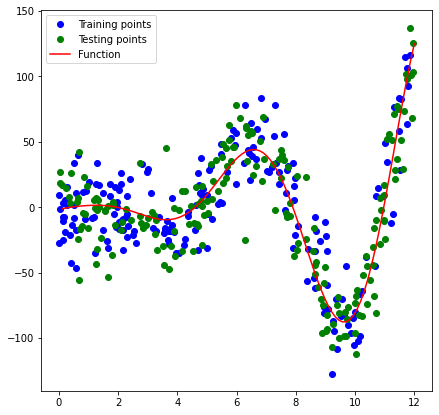

In [5]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show

**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [6]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe

# 
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

Define neural network

In [7]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers



In [8]:
def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [9]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=200)

study.best_params 


[I 2020-12-14 12:37:57,416] A new study created in memory with name: no-name-e63124b3-4c01-4262-b7a6-5c49a67466da
[I 2020-12-14 12:37:57,422] A new study created in memory with name: no-name-bebce7af-a94c-4a11-81f8-ea2f91bcac97


Epoch 00094: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2018 - mse: 1.2018


[I 2020-12-14 12:38:00,480] Trial 0 finished with value: 1.2018145322799683 and parameters: {'units': 55.0, 'dropout': 0.05563142398770715, 'lr': 0.0012454516548527706, 'activation': 'linear'}. Best is trial 0 with value: 1.2018145322799683.


Epoch 00091: early stopping
7/7 [==============================] - 0s 7ms/step - loss: 1.2018 - mse: 1.2018


[I 2020-12-14 12:38:14,452] Trial 1 finished with value: 1.201817274093628 and parameters: {'units': 1575.0, 'dropout': 0.3861641758274105, 'lr': 0.0006934711903651013, 'activation': 'sigmoid'}. Best is trial 0 with value: 1.2018145322799683.


Epoch 00110: early stopping
7/7 [==============================] - 0s 6ms/step - loss: 1.2072 - mse: 1.2072


[I 2020-12-14 12:38:33,160] Trial 2 finished with value: 1.207192063331604 and parameters: {'units': 1707.0, 'dropout': 0.03694224759303966, 'lr': 0.0016912106233778331, 'activation': 'linear'}. Best is trial 0 with value: 1.2018145322799683.


Epoch 00085: early stopping
7/7 [==============================] - 0s 1ms/step - loss: 1.2016 - mse: 1.2016


[I 2020-12-14 12:38:35,290] Trial 3 finished with value: 1.20164155960083 and parameters: {'units': 51.0, 'dropout': 0.2300072739925022, 'lr': 0.0007076593113956525, 'activation': 'linear'}. Best is trial 3 with value: 1.20164155960083.


Epoch 00064: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2010 - mse: 1.2010


[I 2020-12-14 12:38:37,141] Trial 4 finished with value: 1.20099675655365 and parameters: {'units': 130.0, 'dropout': 0.4851296337472991, 'lr': 0.0005243185698728125, 'activation': 'linear'}. Best is trial 4 with value: 1.20099675655365.


Epoch 00104: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2162 - mse: 1.2162


[I 2020-12-14 12:38:43,225] Trial 5 finished with value: 1.21615469455719 and parameters: {'units': 743.0, 'dropout': 0.47360412298577054, 'lr': 0.0009454084850098897, 'activation': 'linear'}. Best is trial 4 with value: 1.20099675655365.


Epoch 00057: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 1.7735 - mse: 1.7735


[I 2020-12-14 12:38:48,483] Trial 6 finished with value: 1.7734962701797485 and parameters: {'units': 1066.0, 'dropout': 0.20798775473039127, 'lr': 0.001855145410105774, 'activation': 'sigmoid'}. Best is trial 4 with value: 1.20099675655365.


Epoch 00145: early stopping
7/7 [==============================] - 0s 7ms/step - loss: 0.3101 - mse: 0.3101


[I 2020-12-14 12:39:16,594] Trial 7 finished with value: 0.310084730386734 and parameters: {'units': 1827.0, 'dropout': 0.1534305202011717, 'lr': 0.001145822846826586, 'activation': 'relu'}. Best is trial 7 with value: 0.310084730386734.


Epoch 00172: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2389 - mse: 1.2389


[I 2020-12-14 12:39:21,341] Trial 8 finished with value: 1.238905668258667 and parameters: {'units': 156.0, 'dropout': 0.16252319742630672, 'lr': 0.001169827452248266, 'activation': 'sigmoid'}. Best is trial 7 with value: 0.310084730386734.


Epoch 00211: early stopping
7/7 [==============================] - 0s 5ms/step - loss: 0.3803 - mse: 0.3803


[I 2020-12-14 12:39:45,093] Trial 9 finished with value: 0.3803071975708008 and parameters: {'units': 1332.0, 'dropout': 0.33574082213526163, 'lr': 0.0010813642262078834, 'activation': 'relu'}. Best is trial 7 with value: 0.310084730386734.


Epoch 00201: early stopping
7/7 [==============================] - 0s 13ms/step - loss: 0.2566 - mse: 0.2566


[I 2020-12-14 12:40:31,509] Trial 10 finished with value: 0.2565825581550598 and parameters: {'units': 2003.0, 'dropout': 0.1359429848390683, 'lr': 0.0014866109894279623, 'activation': 'relu'}. Best is trial 10 with value: 0.2565825581550598.


Epoch 00181: early stopping
7/7 [==============================] - 0s 8ms/step - loss: 0.2523 - mse: 0.2523


[I 2020-12-14 12:41:20,344] Trial 11 finished with value: 0.2523421347141266 and parameters: {'units': 2032.0, 'dropout': 0.11755353411543928, 'lr': 0.0014790445594081143, 'activation': 'relu'}. Best is trial 11 with value: 0.2523421347141266.


Epoch 00147: early stopping
7/7 [==============================] - 0s 9ms/step - loss: 0.2630 - mse: 0.2630


[I 2020-12-14 12:41:54,497] Trial 12 finished with value: 0.263031929731369 and parameters: {'units': 2027.0, 'dropout': 0.07375905726078717, 'lr': 0.0015242558803880643, 'activation': 'relu'}. Best is trial 11 with value: 0.2523421347141266.


Epoch 00172: early stopping
7/7 [==============================] - 0s 8ms/step - loss: 0.2449 - mse: 0.2449


[I 2020-12-14 12:42:35,131] Trial 13 finished with value: 0.24491223692893982 and parameters: {'units': 2031.0, 'dropout': 0.11321932689433178, 'lr': 0.001493798878511646, 'activation': 'relu'}. Best is trial 13 with value: 0.24491223692893982.


Epoch 00199: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2843 - mse: 0.2843


[I 2020-12-14 12:42:43,265] Trial 14 finished with value: 0.28425711393356323 and parameters: {'units': 560.0, 'dropout': 0.0013209204826921395, 'lr': 0.0019254558636502624, 'activation': 'relu'}. Best is trial 13 with value: 0.24491223692893982.


Epoch 00188: early stopping
7/7 [==============================] - 0s 5ms/step - loss: 0.2535 - mse: 0.2535


[I 2020-12-14 12:43:07,888] Trial 15 finished with value: 0.2534904181957245 and parameters: {'units': 1444.0, 'dropout': 0.3104176398116262, 'lr': 0.0014074601826715855, 'activation': 'relu'}. Best is trial 13 with value: 0.24491223692893982.


Epoch 00152: early stopping
7/7 [==============================] - 0s 8ms/step - loss: 0.2546 - mse: 0.2546


[I 2020-12-14 12:43:47,099] Trial 16 finished with value: 0.25459572672843933 and parameters: {'units': 2048.0, 'dropout': 0.09609981809434795, 'lr': 0.0009146973800554369, 'activation': 'relu'}. Best is trial 13 with value: 0.24491223692893982.


Epoch 00124: early stopping
7/7 [==============================] - 0s 6ms/step - loss: 0.2659 - mse: 0.2659


[I 2020-12-14 12:44:11,037] Trial 17 finished with value: 0.26585760712623596 and parameters: {'units': 1825.0, 'dropout': 0.11148252126468071, 'lr': 0.001957964396776927, 'activation': 'relu'}. Best is trial 13 with value: 0.24491223692893982.


Epoch 00206: early stopping
7/7 [==============================] - 0s 5ms/step - loss: 0.4242 - mse: 0.4242


[I 2020-12-14 12:44:31,683] Trial 18 finished with value: 0.42419347167015076 and parameters: {'units': 1217.0, 'dropout': 0.01119201564326415, 'lr': 0.0013661526149961686, 'activation': 'relu'}. Best is trial 13 with value: 0.24491223692893982.


Epoch 00119: early stopping
7/7 [==============================] - 0s 5ms/step - loss: 0.3268 - mse: 0.3268


[I 2020-12-14 12:44:51,288] Trial 19 finished with value: 0.32680779695510864 and parameters: {'units': 1623.0, 'dropout': 0.18531164245927545, 'lr': 0.0016778064731566235, 'activation': 'relu'}. Best is trial 13 with value: 0.24491223692893982.


Epoch 00194: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2336 - mse: 0.2336


[I 2020-12-14 12:45:01,652] Trial 20 finished with value: 0.23363861441612244 and parameters: {'units': 747.0, 'dropout': 0.2834540280764527, 'lr': 0.0008453775555838845, 'activation': 'relu'}. Best is trial 20 with value: 0.23363861441612244.


Epoch 00254: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2573 - mse: 0.2573


[I 2020-12-14 12:45:13,311] Trial 21 finished with value: 0.25729501247406006 and parameters: {'units': 654.0, 'dropout': 0.2853202193617308, 'lr': 0.0008083090640793168, 'activation': 'relu'}. Best is trial 20 with value: 0.23363861441612244.


Epoch 00252: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.3252 - mse: 0.3252


[I 2020-12-14 12:45:22,151] Trial 22 finished with value: 0.3252341151237488 and parameters: {'units': 462.0, 'dropout': 0.2562414649735263, 'lr': 0.0008237997618444553, 'activation': 'relu'}. Best is trial 20 with value: 0.23363861441612244.


Epoch 00234: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2356 - mse: 0.2356


[I 2020-12-14 12:45:37,055] Trial 23 finished with value: 0.23563140630722046 and parameters: {'units': 883.0, 'dropout': 0.2576574017522819, 'lr': 0.0005997206747670312, 'activation': 'relu'}. Best is trial 20 with value: 0.23363861441612244.


Epoch 00304: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2317 - mse: 0.2317


[I 2020-12-14 12:45:55,826] Trial 24 finished with value: 0.23172403872013092 and parameters: {'units': 857.0, 'dropout': 0.373396561357756, 'lr': 0.0005168372650929572, 'activation': 'relu'}. Best is trial 24 with value: 0.23172403872013092.


Epoch 00282: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2433 - mse: 0.2433


[I 2020-12-14 12:46:13,472] Trial 25 finished with value: 0.2433144599199295 and parameters: {'units': 862.0, 'dropout': 0.388107109604264, 'lr': 0.0005334068462341013, 'activation': 'relu'}. Best is trial 24 with value: 0.23172403872013092.


Epoch 00072: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.3386 - mse: 1.3386


[I 2020-12-14 12:46:16,228] Trial 26 finished with value: 1.3386441469192505 and parameters: {'units': 367.0, 'dropout': 0.3705221914045792, 'lr': 0.0005996110828660362, 'activation': 'sigmoid'}. Best is trial 24 with value: 0.23172403872013092.


Epoch 00320: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2302 - mse: 0.2302


[I 2020-12-14 12:46:38,962] Trial 27 finished with value: 0.23021546006202698 and parameters: {'units': 963.0, 'dropout': 0.41384310360675336, 'lr': 0.0006005081247488558, 'activation': 'relu'}. Best is trial 27 with value: 0.23021546006202698.


Epoch 00313: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3292 - mse: 0.3292


[I 2020-12-14 12:47:02,388] Trial 28 finished with value: 0.3292245864868164 and parameters: {'units': 997.0, 'dropout': 0.4293403321359021, 'lr': 0.000602975948969859, 'activation': 'relu'}. Best is trial 27 with value: 0.23021546006202698.


Epoch 00269: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2951 - mse: 0.2951


[I 2020-12-14 12:47:24,923] Trial 29 finished with value: 0.2951282262802124 and parameters: {'units': 1078.0, 'dropout': 0.43304802982204305, 'lr': 0.0005061250617034948, 'activation': 'relu'}. Best is trial 27 with value: 0.23021546006202698.


Epoch 00357: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2651 - mse: 0.2651


[I 2020-12-14 12:47:35,234] Trial 30 finished with value: 0.26506751775741577 and parameters: {'units': 311.0, 'dropout': 0.3481825700359372, 'lr': 0.0006940323214706432, 'activation': 'relu'}. Best is trial 27 with value: 0.23021546006202698.


Epoch 00290: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2291 - mse: 0.2291


[I 2020-12-14 12:47:53,088] Trial 31 finished with value: 0.22909650206565857 and parameters: {'units': 856.0, 'dropout': 0.25972020199204293, 'lr': 0.0005649924665824145, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00290: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2467 - mse: 0.2467


[I 2020-12-14 12:48:08,733] Trial 32 finished with value: 0.24674707651138306 and parameters: {'units': 770.0, 'dropout': 0.309518443908916, 'lr': 0.0005612507948496525, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00234: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.3365 - mse: 0.3365


[I 2020-12-14 12:48:30,723] Trial 33 finished with value: 0.3365410566329956 and parameters: {'units': 1192.0, 'dropout': 0.4229317090197579, 'lr': 0.0006521882538506027, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00136: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 1.2642 - mse: 1.2642


[I 2020-12-14 12:48:40,845] Trial 34 finished with value: 1.2642346620559692 and parameters: {'units': 941.0, 'dropout': 0.28829830213762614, 'lr': 0.0007718670395135134, 'activation': 'sigmoid'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00265: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2662 - mse: 0.2662


[I 2020-12-14 12:48:54,486] Trial 35 finished with value: 0.26619669795036316 and parameters: {'units': 726.0, 'dropout': 0.4028347407287166, 'lr': 0.0006519583792989812, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00183: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2009 - mse: 1.2009


[I 2020-12-14 12:49:01,901] Trial 36 finished with value: 1.20089590549469 and parameters: {'units': 556.0, 'dropout': 0.2280660876525185, 'lr': 0.0005575429778422597, 'activation': 'linear'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00083: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 1.2006 - mse: 1.2006


[I 2020-12-14 12:49:10,038] Trial 37 finished with value: 1.2005687952041626 and parameters: {'units': 1169.0, 'dropout': 0.45856341372608694, 'lr': 0.0007519879271164363, 'activation': 'linear'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00264: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2355 - mse: 0.2355


[I 2020-12-14 12:49:25,950] Trial 38 finished with value: 0.23550771176815033 and parameters: {'units': 844.0, 'dropout': 0.341691342284304, 'lr': 0.0005096220867720844, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00124: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 1.2160 - mse: 1.2160


[I 2020-12-14 12:49:31,777] Trial 39 finished with value: 1.216027855873108 and parameters: {'units': 640.0, 'dropout': 0.3629485461978387, 'lr': 0.0008714423244971056, 'activation': 'sigmoid'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00052: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 1.2531 - mse: 1.2531


[I 2020-12-14 12:49:36,310] Trial 40 finished with value: 1.253056287765503 and parameters: {'units': 1044.0, 'dropout': 0.2833552637232422, 'lr': 0.0006388390586229795, 'activation': 'linear'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00294: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2308 - mse: 0.2308


[I 2020-12-14 12:49:54,421] Trial 41 finished with value: 0.23075738549232483 and parameters: {'units': 833.0, 'dropout': 0.3145049597882464, 'lr': 0.0005090601358859273, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00263: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2635 - mse: 0.2635


[I 2020-12-14 12:50:08,547] Trial 42 finished with value: 0.26350104808807373 and parameters: {'units': 772.0, 'dropout': 0.31591009910748247, 'lr': 0.0005557158044011154, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00237: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2759 - mse: 0.2759


[I 2020-12-14 12:50:24,821] Trial 43 finished with value: 0.2758757472038269 and parameters: {'units': 943.0, 'dropout': 0.4966085874709115, 'lr': 0.0010471385286580643, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00236: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.3284 - mse: 0.3284


[I 2020-12-14 12:50:50,790] Trial 44 finished with value: 0.328354150056839 and parameters: {'units': 1336.0, 'dropout': 0.40286690113161483, 'lr': 0.000507498295348387, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00226: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2484 - mse: 0.2484


[I 2020-12-14 12:51:01,192] Trial 45 finished with value: 0.24840047955513 and parameters: {'units': 619.0, 'dropout': 0.2282637750451924, 'lr': 0.0005758140355501892, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00225: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.3065 - mse: 0.3065


[I 2020-12-14 12:51:20,435] Trial 46 finished with value: 0.3065340518951416 and parameters: {'units': 1108.0, 'dropout': 0.20148652063880934, 'lr': 0.0007230636183855381, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00265: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2430 - mse: 0.2430


[I 2020-12-14 12:51:35,637] Trial 47 finished with value: 0.24298836290836334 and parameters: {'units': 809.0, 'dropout': 0.333737870321441, 'lr': 0.0005317467929841475, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00234: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3156 - mse: 0.3156


[I 2020-12-14 12:51:52,278] Trial 48 finished with value: 0.3156237304210663 and parameters: {'units': 959.0, 'dropout': 0.2718471508214126, 'lr': 0.0006309822946579877, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00283: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2689 - mse: 0.2689


[I 2020-12-14 12:52:06,290] Trial 49 finished with value: 0.2688591480255127 and parameters: {'units': 709.0, 'dropout': 0.3692614508436895, 'lr': 0.0006896857459650302, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00253: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2556 - mse: 0.2556


[I 2020-12-14 12:52:15,689] Trial 50 finished with value: 0.25563377141952515 and parameters: {'units': 510.0, 'dropout': 0.30606087957859696, 'lr': 0.0009804010360995694, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00279: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2821 - mse: 0.2821


[I 2020-12-14 12:52:32,644] Trial 51 finished with value: 0.2821127772331238 and parameters: {'units': 854.0, 'dropout': 0.3416032892686022, 'lr': 0.0005071077329820062, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00327: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2674 - mse: 0.2674


[I 2020-12-14 12:52:54,969] Trial 52 finished with value: 0.2674165368080139 and parameters: {'units': 927.0, 'dropout': 0.4551562491349467, 'lr': 0.0005300339175075529, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00254: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2870 - mse: 0.2870


[I 2020-12-14 12:53:10,161] Trial 53 finished with value: 0.2869524359703064 and parameters: {'units': 833.0, 'dropout': 0.32664563334314173, 'lr': 0.0005065115373758023, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00291: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2377 - mse: 0.2377


[I 2020-12-14 12:53:40,364] Trial 54 finished with value: 0.23771069943904877 and parameters: {'units': 1296.0, 'dropout': 0.3530851610954342, 'lr': 0.0005003326963244601, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00259: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2451 - mse: 0.2451


[I 2020-12-14 12:53:53,655] Trial 55 finished with value: 0.2451392412185669 and parameters: {'units': 716.0, 'dropout': 0.38280223328852325, 'lr': 0.0005883358838418269, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00295: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2304 - mse: 0.2304


[I 2020-12-14 12:54:03,929] Trial 56 finished with value: 0.23041893541812897 and parameters: {'units': 435.0, 'dropout': 0.2474060845572083, 'lr': 0.0005563029625799998, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00487: early stopping
7/7 [==============================] - 0s 1ms/step - loss: 0.2363 - mse: 0.2363


[I 2020-12-14 12:54:15,563] Trial 57 finished with value: 0.23628106713294983 and parameters: {'units': 228.0, 'dropout': 0.25275031703946205, 'lr': 0.0006210319290446867, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00061: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.3149 - mse: 1.3149


[I 2020-12-14 12:54:18,369] Trial 58 finished with value: 1.3148829936981201 and parameters: {'units': 473.0, 'dropout': 0.21088941604033423, 'lr': 0.0012504086737678407, 'activation': 'sigmoid'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00373: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2482 - mse: 0.2482


[I 2020-12-14 12:54:29,784] Trial 59 finished with value: 0.24817489087581635 and parameters: {'units': 370.0, 'dropout': 0.170538880701269, 'lr': 0.0005493616760717873, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00066: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.3223 - mse: 1.3223


[I 2020-12-14 12:54:33,021] Trial 60 finished with value: 1.3223047256469727 and parameters: {'units': 595.0, 'dropout': 0.29616971188056634, 'lr': 0.0006630527261790053, 'activation': 'linear'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00245: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2670 - mse: 0.2670


[I 2020-12-14 12:54:51,641] Trial 61 finished with value: 0.2670210599899292 and parameters: {'units': 1001.0, 'dropout': 0.2730204267226727, 'lr': 0.0005794446527358997, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00253: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2530 - mse: 0.2530


[I 2020-12-14 12:55:04,401] Trial 62 finished with value: 0.2530406713485718 and parameters: {'units': 678.0, 'dropout': 0.23671927786959412, 'lr': 0.0005289606101439519, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


7/7 [==============================] - 0s 2ms/step - loss: 0.6462 - mse: 0.6462


[I 2020-12-14 12:55:14,819] Trial 63 finished with value: 0.6461517214775085 and parameters: {'units': 63.0, 'dropout': 0.3226577833356353, 'lr': 0.0005418899746179575, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00265: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2590 - mse: 0.2590


[I 2020-12-14 12:55:31,484] Trial 64 finished with value: 0.25902995467185974 and parameters: {'units': 881.0, 'dropout': 0.38203018797745714, 'lr': 0.0006116663046241198, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00209: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.3376 - mse: 0.3376


[I 2020-12-14 12:55:49,961] Trial 65 finished with value: 0.3376254737377167 and parameters: {'units': 1126.0, 'dropout': 0.2658239989333754, 'lr': 0.000585146021324201, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00295: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2576 - mse: 0.2576


[I 2020-12-14 12:56:06,517] Trial 66 finished with value: 0.2576219439506531 and parameters: {'units': 785.0, 'dropout': 0.29267200203640487, 'lr': 0.0005180030396468756, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00239: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2346 - mse: 0.2346


[I 2020-12-14 12:56:24,503] Trial 67 finished with value: 0.23462890088558197 and parameters: {'units': 995.0, 'dropout': 0.41454553565634406, 'lr': 0.000570162957948914, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00277: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3115 - mse: 0.3115


[I 2020-12-14 12:56:46,215] Trial 68 finished with value: 0.3114762604236603 and parameters: {'units': 1046.0, 'dropout': 0.403381033279951, 'lr': 0.0005701629913645679, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00222: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2363 - mse: 0.2363


[I 2020-12-14 12:57:08,265] Trial 69 finished with value: 0.23634429275989532 and parameters: {'units': 1227.0, 'dropout': 0.44558078692320874, 'lr': 0.0007311720878253214, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00167: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3737 - mse: 0.3737


[I 2020-12-14 12:57:20,934] Trial 70 finished with value: 0.37368619441986084 and parameters: {'units': 995.0, 'dropout': 0.21239558675724754, 'lr': 0.0008328080825395969, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00284: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2411 - mse: 0.2411


[I 2020-12-14 12:57:38,859] Trial 71 finished with value: 0.24110881984233856 and parameters: {'units': 912.0, 'dropout': 0.24256617529422256, 'lr': 0.0005010153581570926, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00317: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2669 - mse: 0.2669


[I 2020-12-14 12:57:57,555] Trial 72 finished with value: 0.2668595016002655 and parameters: {'units': 821.0, 'dropout': 0.4735479954622185, 'lr': 0.0006798752052492226, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00297: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2728 - mse: 0.2728


[I 2020-12-14 12:58:12,752] Trial 73 finished with value: 0.2727825343608856 and parameters: {'units': 738.0, 'dropout': 0.4111132853836939, 'lr': 0.0005522086887554347, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00331: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2316 - mse: 0.2316


[I 2020-12-14 12:58:33,472] Trial 74 finished with value: 0.23164533078670502 and parameters: {'units': 881.0, 'dropout': 0.357159821030538, 'lr': 0.0006126541050649952, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00220: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2547 - mse: 0.2547


[I 2020-12-14 12:58:49,737] Trial 75 finished with value: 0.2547285258769989 and parameters: {'units': 985.0, 'dropout': 0.35239447772336624, 'lr': 0.0006311787117640048, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00245: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2476 - mse: 0.2476


[I 2020-12-14 12:59:10,319] Trial 76 finished with value: 0.24757589399814606 and parameters: {'units': 1100.0, 'dropout': 0.4161949708367075, 'lr': 0.0006046075518578205, 'activation': 'relu'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00069: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2718 - mse: 1.2718


[I 2020-12-14 12:59:13,158] Trial 77 finished with value: 1.2717703580856323 and parameters: {'units': 415.0, 'dropout': 0.4366574280705479, 'lr': 0.0006699757770040132, 'activation': 'sigmoid'}. Best is trial 31 with value: 0.22909650206565857.


Epoch 00247: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2237 - mse: 0.2237


[I 2020-12-14 12:59:29,531] Trial 78 finished with value: 0.22374753654003143 and parameters: {'units': 895.0, 'dropout': 0.37114313884992534, 'lr': 0.0005651994412092666, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00284: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2303 - mse: 0.2303


[I 2020-12-14 12:59:40,977] Trial 79 finished with value: 0.23025956749916077 and parameters: {'units': 562.0, 'dropout': 0.3869949620107017, 'lr': 0.0007871631925196715, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00126: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2010 - mse: 1.2010


[I 2020-12-14 12:59:44,765] Trial 80 finished with value: 1.201043963432312 and parameters: {'units': 270.0, 'dropout': 0.3868919464944806, 'lr': 0.000772169547473398, 'activation': 'linear'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00294: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2321 - mse: 0.2321


[I 2020-12-14 12:59:56,288] Trial 81 finished with value: 0.2321198433637619 and parameters: {'units': 543.0, 'dropout': 0.3586030309850928, 'lr': 0.0008092931208265558, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00230: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2401 - mse: 0.2401


[I 2020-12-14 13:00:05,961] Trial 82 finished with value: 0.2400975376367569 and parameters: {'units': 585.0, 'dropout': 0.3638379580781854, 'lr': 0.0008828598508321849, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00289: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2838 - mse: 0.2838


[I 2020-12-14 13:00:16,804] Trial 83 finished with value: 0.28382426500320435 and parameters: {'units': 499.0, 'dropout': 0.3758063067638878, 'lr': 0.0009190434263227115, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00265: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.3310 - mse: 0.3310


[I 2020-12-14 13:00:29,610] Trial 84 finished with value: 0.33098316192626953 and parameters: {'units': 664.0, 'dropout': 0.39895716943789034, 'lr': 0.0007923928627240144, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00280: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2241 - mse: 0.2241


[I 2020-12-14 13:00:41,096] Trial 85 finished with value: 0.22407618165016174 and parameters: {'units': 537.0, 'dropout': 0.3589667800134089, 'lr': 0.0006383587387643448, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00332: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2463 - mse: 0.2463


[I 2020-12-14 13:00:52,213] Trial 86 finished with value: 0.2462914139032364 and parameters: {'units': 422.0, 'dropout': 0.3941602033211821, 'lr': 0.0005988561739591389, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00184: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2329 - mse: 0.2329


[I 2020-12-14 13:01:04,438] Trial 87 finished with value: 0.2329094111919403 and parameters: {'units': 908.0, 'dropout': 0.3336239117948763, 'lr': 0.0006530069708809612, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00300: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2597 - mse: 0.2597


[I 2020-12-14 13:01:18,750] Trial 88 finished with value: 0.25967440009117126 and parameters: {'units': 678.0, 'dropout': 0.3039573306312669, 'lr': 0.0005405184695787219, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


7/7 [==============================] - 0s 1ms/step - loss: 0.2389 - mse: 0.2389


[I 2020-12-14 13:01:30,525] Trial 89 finished with value: 0.2388789802789688 and parameters: {'units': 179.0, 'dropout': 0.3699459007568174, 'lr': 0.0006224803578723688, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00303: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2546 - mse: 0.2546


[I 2020-12-14 13:01:47,294] Trial 90 finished with value: 0.2546478807926178 and parameters: {'units': 788.0, 'dropout': 0.3459146208390469, 'lr': 0.0005206889132388099, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00315: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2432 - mse: 0.2432


[I 2020-12-14 13:01:59,473] Trial 91 finished with value: 0.2432439774274826 and parameters: {'units': 530.0, 'dropout': 0.35852998827710897, 'lr': 0.0007120827140832054, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00343: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.3159 - mse: 0.3159


[I 2020-12-14 13:02:10,909] Trial 92 finished with value: 0.31586745381355286 and parameters: {'units': 412.0, 'dropout': 0.3251780193747711, 'lr': 0.0007479057390723803, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00424: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2706 - mse: 0.2706


[I 2020-12-14 13:02:23,009] Trial 93 finished with value: 0.2705577313899994 and parameters: {'units': 320.0, 'dropout': 0.378796268045271, 'lr': 0.0005643103212616781, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00254: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2630 - mse: 0.2630


[I 2020-12-14 13:02:34,173] Trial 94 finished with value: 0.26296907663345337 and parameters: {'units': 622.0, 'dropout': 0.3552340599151388, 'lr': 0.0005889061691985813, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00285: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2393 - mse: 0.2393


[I 2020-12-14 13:02:45,809] Trial 95 finished with value: 0.23932762444019318 and parameters: {'units': 559.0, 'dropout': 0.3912489824304888, 'lr': 0.000647463111852086, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00220: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2285 - mse: 0.2285


[I 2020-12-14 13:02:59,305] Trial 96 finished with value: 0.22846108675003052 and parameters: {'units': 841.0, 'dropout': 0.3187622392773648, 'lr': 0.0006979812530357876, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00233: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2476 - mse: 0.2476


[I 2020-12-14 13:03:14,636] Trial 97 finished with value: 0.24763041734695435 and parameters: {'units': 882.0, 'dropout': 0.33337662291596243, 'lr': 0.0006211067327438938, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00253: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3120 - mse: 0.3120


[I 2020-12-14 13:03:30,265] Trial 98 finished with value: 0.3120483458042145 and parameters: {'units': 851.0, 'dropout': 0.42342377709150375, 'lr': 0.0006971150104885924, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00212: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2423 - mse: 0.2423


[I 2020-12-14 13:03:41,511] Trial 99 finished with value: 0.24226754903793335 and parameters: {'units': 742.0, 'dropout': 0.3147704247234795, 'lr': 0.0006770135923296183, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00165: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 1.2274 - mse: 1.2274


[I 2020-12-14 13:03:53,495] Trial 100 finished with value: 1.2273750305175781 and parameters: {'units': 957.0, 'dropout': 0.2634224983078247, 'lr': 0.0005471104436958833, 'activation': 'sigmoid'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00323: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2425 - mse: 0.2425


[I 2020-12-14 13:04:05,387] Trial 101 finished with value: 0.24246837198734283 and parameters: {'units': 461.0, 'dropout': 0.3430737749486965, 'lr': 0.000643622394981328, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00220: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2837 - mse: 0.2837


[I 2020-12-14 13:04:18,240] Trial 102 finished with value: 0.28373199701309204 and parameters: {'units': 814.0, 'dropout': 0.3011723553916578, 'lr': 0.0007909840254582227, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00264: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2608 - mse: 0.2608


[I 2020-12-14 13:04:31,332] Trial 103 finished with value: 0.2607511579990387 and parameters: {'units': 697.0, 'dropout': 0.2782922861724975, 'lr': 0.0005968001227794796, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00203: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2886 - mse: 0.2886


[I 2020-12-14 13:04:47,461] Trial 104 finished with value: 0.2886161506175995 and parameters: {'units': 1035.0, 'dropout': 0.3634492724732793, 'lr': 0.0007448085917573124, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00330: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2689 - mse: 0.2689


[I 2020-12-14 13:05:05,243] Trial 105 finished with value: 0.26888221502304077 and parameters: {'units': 766.0, 'dropout': 0.37324987969516377, 'lr': 0.0005773855368414976, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00334: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2353 - mse: 0.2353


[I 2020-12-14 13:05:19,722] Trial 106 finished with value: 0.23534156382083893 and parameters: {'units': 623.0, 'dropout': 0.3167094487548642, 'lr': 0.0007123929388075884, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00196: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2817 - mse: 0.2817


[I 2020-12-14 13:05:32,857] Trial 107 finished with value: 0.28171849250793457 and parameters: {'units': 905.0, 'dropout': 0.34760669882654077, 'lr': 0.0006117242507327044, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00054: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2066 - mse: 1.2066


[I 2020-12-14 13:05:35,020] Trial 108 finished with value: 1.206589937210083 and parameters: {'units': 332.0, 'dropout': 0.40574703345248486, 'lr': 0.0005332953965046839, 'activation': 'linear'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00184: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.3344 - mse: 0.3344


[I 2020-12-14 13:05:52,716] Trial 109 finished with value: 0.3344472050666809 and parameters: {'units': 1147.0, 'dropout': 0.39279394042367444, 'lr': 0.0008534850887163879, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00227: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2308 - mse: 0.2308


[I 2020-12-14 13:06:08,965] Trial 110 finished with value: 0.23082172870635986 and parameters: {'units': 964.0, 'dropout': 0.21988114280266594, 'lr': 0.0005588207486691634, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00193: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2320 - mse: 0.2320


[I 2020-12-14 13:06:25,290] Trial 111 finished with value: 0.2320251613855362 and parameters: {'units': 1079.0, 'dropout': 0.18896764824644713, 'lr': 0.0005534117442282717, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00258: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2336 - mse: 0.2336


[I 2020-12-14 13:06:46,461] Trial 112 finished with value: 0.23359926044940948 and parameters: {'units': 1054.0, 'dropout': 0.19928615072104053, 'lr': 0.000518008131143342, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00248: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2440 - mse: 0.2440


[I 2020-12-14 13:07:03,583] Trial 113 finished with value: 0.24402156472206116 and parameters: {'units': 952.0, 'dropout': 0.18304892600343234, 'lr': 0.000559908084791433, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00253: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2625 - mse: 0.2625


[I 2020-12-14 13:07:25,066] Trial 114 finished with value: 0.26248157024383545 and parameters: {'units': 1095.0, 'dropout': 0.2192069353915061, 'lr': 0.0005800701658476014, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00219: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2642 - mse: 0.2642


[I 2020-12-14 13:07:46,644] Trial 115 finished with value: 0.26419350504875183 and parameters: {'units': 1220.0, 'dropout': 0.13777190734777994, 'lr': 0.0005433467467699468, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00251: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2332 - mse: 0.2332


[I 2020-12-14 13:08:02,257] Trial 116 finished with value: 0.233226478099823 and parameters: {'units': 868.0, 'dropout': 0.2375430082954171, 'lr': 0.0005606292738151009, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00251: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3102 - mse: 0.3102


[I 2020-12-14 13:08:21,533] Trial 117 finished with value: 0.310194730758667 and parameters: {'units': 987.0, 'dropout': 0.19188897291895196, 'lr': 0.0005225674110034643, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00276: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2350 - mse: 0.2350


[I 2020-12-14 13:08:40,162] Trial 118 finished with value: 0.23504891991615295 and parameters: {'units': 922.0, 'dropout': 0.24548818353290175, 'lr': 0.0005004906090911375, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00230: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.3320 - mse: 0.3320


[I 2020-12-14 13:08:58,489] Trial 119 finished with value: 0.331965833902359 and parameters: {'units': 1028.0, 'dropout': 0.2204092433248699, 'lr': 0.0006155513647700183, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00241: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2527 - mse: 0.2527


[I 2020-12-14 13:09:13,150] Trial 120 finished with value: 0.2526680529117584 and parameters: {'units': 836.0, 'dropout': 0.17679746287093215, 'lr': 0.000636768819677038, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00242: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2662 - mse: 0.2662


[I 2020-12-14 13:09:27,298] Trial 121 finished with value: 0.26621052622795105 and parameters: {'units': 797.0, 'dropout': 0.16272379225696376, 'lr': 0.000590488956744962, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00287: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2850 - mse: 0.2850


[I 2020-12-14 13:09:38,450] Trial 122 finished with value: 0.28499355912208557 and parameters: {'units': 526.0, 'dropout': 0.38186815020213843, 'lr': 0.000663288792714495, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00255: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2736 - mse: 0.2736


[I 2020-12-14 13:09:59,588] Trial 123 finished with value: 0.2736174762248993 and parameters: {'units': 1078.0, 'dropout': 0.36078975544283426, 'lr': 0.0005697063173778546, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00208: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2614 - mse: 0.2614


[I 2020-12-14 13:10:12,762] Trial 124 finished with value: 0.261430561542511 and parameters: {'units': 888.0, 'dropout': 0.25892540952269455, 'lr': 0.0009985179472545979, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00327: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2510 - mse: 0.2510


[I 2020-12-14 13:10:24,930] Trial 125 finished with value: 0.2510499656200409 and parameters: {'units': 453.0, 'dropout': 0.3272142639694851, 'lr': 0.0005389095506055296, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00273: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.4137 - mse: 0.4137


[I 2020-12-14 13:10:44,733] Trial 126 finished with value: 0.4136565327644348 and parameters: {'units': 967.0, 'dropout': 0.22718829940916735, 'lr': 0.0005517767765355174, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00302: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2355 - mse: 0.2355


[I 2020-12-14 13:11:00,709] Trial 127 finished with value: 0.23548512160778046 and parameters: {'units': 717.0, 'dropout': 0.28747011938078076, 'lr': 0.0006042063298352598, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00242: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2917 - mse: 0.2917


[I 2020-12-14 13:11:08,782] Trial 128 finished with value: 0.29169437289237976 and parameters: {'units': 378.0, 'dropout': 0.3393931422627317, 'lr': 0.0010688983133873497, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00283: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2694 - mse: 0.2694


[I 2020-12-14 13:11:20,640] Trial 129 finished with value: 0.26943016052246094 and parameters: {'units': 589.0, 'dropout': 0.20150588552817666, 'lr': 0.0005156904128666977, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00057: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 4.2384 - mse: 4.2384


[I 2020-12-14 13:11:25,140] Trial 130 finished with value: 4.238373756408691 and parameters: {'units': 934.0, 'dropout': 0.3710186904663861, 'lr': 0.0006308640300635491, 'activation': 'sigmoid'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00225: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3746 - mse: 0.3746


[I 2020-12-14 13:11:39,597] Trial 131 finished with value: 0.37455734610557556 and parameters: {'units': 887.0, 'dropout': 0.35789787719348076, 'lr': 0.0005811912504147096, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00201: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2410 - mse: 0.2410


[I 2020-12-14 13:11:54,808] Trial 132 finished with value: 0.24099542200565338 and parameters: {'units': 1016.0, 'dropout': 0.33050387304985196, 'lr': 0.0006550702932783931, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00203: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3145 - mse: 0.3145


[I 2020-12-14 13:12:08,431] Trial 133 finished with value: 0.31450697779655457 and parameters: {'units': 918.0, 'dropout': 0.350191123017662, 'lr': 0.000702696674429392, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00215: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3621 - mse: 0.3621


[I 2020-12-14 13:12:21,718] Trial 134 finished with value: 0.362085223197937 and parameters: {'units': 851.0, 'dropout': 0.3122516274073743, 'lr': 0.000686749989072058, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00274: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3346 - mse: 0.3346


[I 2020-12-14 13:12:36,467] Trial 135 finished with value: 0.3346090614795685 and parameters: {'units': 761.0, 'dropout': 0.3367274452844074, 'lr': 0.0009537068856819811, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00221: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2364 - mse: 0.2364


[I 2020-12-14 13:12:49,051] Trial 136 finished with value: 0.23639518022537231 and parameters: {'units': 808.0, 'dropout': 0.25055985083759996, 'lr': 0.0007282102245174441, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00268: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2499 - mse: 0.2499


[I 2020-12-14 13:13:01,806] Trial 137 finished with value: 0.2499237060546875 and parameters: {'units': 651.0, 'dropout': 0.3810785949553357, 'lr': 0.0008102745984594408, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00339: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2353 - mse: 0.2353


[I 2020-12-14 13:13:14,483] Trial 138 finished with value: 0.23528844118118286 and parameters: {'units': 506.0, 'dropout': 0.3669749443237837, 'lr': 0.0005959115736079307, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00096: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 1.2138 - mse: 1.2138


[I 2020-12-14 13:13:24,005] Trial 139 finished with value: 1.2137969732284546 and parameters: {'units': 1166.0, 'dropout': 0.396012252553739, 'lr': 0.0006527246311599833, 'activation': 'linear'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00249: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2336 - mse: 0.2336


[I 2020-12-14 13:13:41,719] Trial 140 finished with value: 0.23360681533813477 and parameters: {'units': 962.0, 'dropout': 0.4204331751516575, 'lr': 0.0006164849404728132, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00283: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2629 - mse: 0.2629


[I 2020-12-14 13:13:59,239] Trial 141 finished with value: 0.2628623843193054 and parameters: {'units': 853.0, 'dropout': 0.23659431234131725, 'lr': 0.0005584507708285399, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00229: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2361 - mse: 0.2361


[I 2020-12-14 13:14:13,581] Trial 142 finished with value: 0.2361120730638504 and parameters: {'units': 869.0, 'dropout': 0.273035812422942, 'lr': 0.0005700505121392507, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00331: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2976 - mse: 0.2976


[I 2020-12-14 13:14:32,756] Trial 143 finished with value: 0.29756781458854675 and parameters: {'units': 818.0, 'dropout': 0.22092853352955785, 'lr': 0.0005281605676776415, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00318: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2493 - mse: 0.2493


[I 2020-12-14 13:14:53,487] Trial 144 finished with value: 0.2492813915014267 and parameters: {'units': 905.0, 'dropout': 0.211937477270079, 'lr': 0.0005591718727232149, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00256: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2483 - mse: 0.2483


[I 2020-12-14 13:15:12,510] Trial 145 finished with value: 0.24828477203845978 and parameters: {'units': 1008.0, 'dropout': 0.2318511292609308, 'lr': 0.0005409665548476899, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00250: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2413 - mse: 0.2413


[I 2020-12-14 13:15:22,573] Trial 146 finished with value: 0.2413010150194168 and parameters: {'units': 552.0, 'dropout': 0.2456025586187249, 'lr': 0.000769286965772231, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00243: early stopping
7/7 [==============================] - 0s 6ms/step - loss: 0.2293 - mse: 0.2293


[I 2020-12-14 13:15:42,281] Trial 147 finished with value: 0.22928528487682343 and parameters: {'units': 1059.0, 'dropout': 0.18972060605743085, 'lr': 0.0005870356712821671, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00201: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.3311 - mse: 0.3311


[I 2020-12-14 13:15:59,447] Trial 148 finished with value: 0.33110591769218445 and parameters: {'units': 1112.0, 'dropout': 0.16092371812157966, 'lr': 0.0006335634877080884, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00212: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2411 - mse: 0.2411


[I 2020-12-14 13:16:17,439] Trial 149 finished with value: 0.24105124175548553 and parameters: {'units': 1073.0, 'dropout': 0.19732753594167968, 'lr': 0.0006051501649231361, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00256: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2977 - mse: 0.2977


[I 2020-12-14 13:16:35,747] Trial 150 finished with value: 0.2976788282394409 and parameters: {'units': 945.0, 'dropout': 0.18642987659926155, 'lr': 0.0005845899048058441, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00207: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3551 - mse: 0.3551


[I 2020-12-14 13:16:52,057] Trial 151 finished with value: 0.3551299273967743 and parameters: {'units': 1038.0, 'dropout': 0.20739337512378128, 'lr': 0.0005663020107111344, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00273: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3215 - mse: 0.3215


[I 2020-12-14 13:17:10,016] Trial 152 finished with value: 0.3214973509311676 and parameters: {'units': 911.0, 'dropout': 0.32258334553605583, 'lr': 0.0005502007374051515, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00212: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2648 - mse: 0.2648


[I 2020-12-14 13:17:21,894] Trial 153 finished with value: 0.26480820775032043 and parameters: {'units': 786.0, 'dropout': 0.347533265697703, 'lr': 0.0006715914061638427, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00237: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2374 - mse: 0.2374


[I 2020-12-14 13:17:39,080] Trial 154 finished with value: 0.23743464052677155 and parameters: {'units': 981.0, 'dropout': 0.2948006173967942, 'lr': 0.000587313295909454, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00264: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.3114 - mse: 0.3114


[I 2020-12-14 13:17:55,187] Trial 155 finished with value: 0.31142857670783997 and parameters: {'units': 868.0, 'dropout': 0.35724330815894684, 'lr': 0.0005325339861610193, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00410: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2320 - mse: 0.2320


[I 2020-12-14 13:18:09,463] Trial 156 finished with value: 0.2320067435503006 and parameters: {'units': 472.0, 'dropout': 0.4078862914657628, 'lr': 0.0005110073724913446, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00370: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2750 - mse: 0.2750


[I 2020-12-14 13:18:22,399] Trial 157 finished with value: 0.27500951290130615 and parameters: {'units': 459.0, 'dropout': 0.4079816817561411, 'lr': 0.0005087120018838223, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00372: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2886 - mse: 0.2886


[I 2020-12-14 13:18:35,026] Trial 158 finished with value: 0.2885892987251282 and parameters: {'units': 424.0, 'dropout': 0.4383229651806641, 'lr': 0.0005202241970983539, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00381: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2419 - mse: 0.2419


[I 2020-12-14 13:18:47,154] Trial 159 finished with value: 0.2419499009847641 and parameters: {'units': 385.0, 'dropout': 0.3948338162905337, 'lr': 0.0006237203627821106, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00281: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2367 - mse: 0.2367


[I 2020-12-14 13:18:57,364] Trial 160 finished with value: 0.2366636097431183 and parameters: {'units': 496.0, 'dropout': 0.14594844989723066, 'lr': 0.0006052786182101837, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00254: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2904 - mse: 0.2904


[I 2020-12-14 13:19:23,709] Trial 161 finished with value: 0.2904430627822876 and parameters: {'units': 1276.0, 'dropout': 0.37450396264627694, 'lr': 0.0005704095871913878, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00232: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.3093 - mse: 0.3093


[I 2020-12-14 13:19:33,074] Trial 162 finished with value: 0.3092555105686188 and parameters: {'units': 555.0, 'dropout': 0.38628433845960664, 'lr': 0.001152201923288973, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00227: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2913 - mse: 0.2913


[I 2020-12-14 13:19:46,286] Trial 163 finished with value: 0.2913196086883545 and parameters: {'units': 832.0, 'dropout': 0.17101803267506205, 'lr': 0.0005444585310646336, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00224: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2362 - mse: 0.2362


[I 2020-12-14 13:20:02,383] Trial 164 finished with value: 0.23619967699050903 and parameters: {'units': 947.0, 'dropout': 0.2626926380820875, 'lr': 0.0005029438556893803, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00193: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2272 - mse: 0.2272


[I 2020-12-14 13:20:14,742] Trial 165 finished with value: 0.22716733813285828 and parameters: {'units': 894.0, 'dropout': 0.42549135783207886, 'lr': 0.0008937947088983099, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00223: early stopping
7/7 [==============================] - 0s 5ms/step - loss: 0.3083 - mse: 0.3083


[I 2020-12-14 13:20:41,424] Trial 166 finished with value: 0.3082968592643738 and parameters: {'units': 1424.0, 'dropout': 0.44673182259075656, 'lr': 0.000932077133795625, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00183: early stopping
7/7 [==============================] - 0s 4ms/step - loss: 0.2477 - mse: 0.2477


[I 2020-12-14 13:20:56,116] Trial 167 finished with value: 0.24765565991401672 and parameters: {'units': 1047.0, 'dropout': 0.40416749677377073, 'lr': 0.0008584552323025384, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00054: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 1.3284 - mse: 1.3284


[I 2020-12-14 13:20:59,474] Trial 168 finished with value: 1.3284428119659424 and parameters: {'units': 740.0, 'dropout': 0.420003450010601, 'lr': 0.0007769434758964085, 'activation': 'sigmoid'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00231: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2663 - mse: 0.2663


[I 2020-12-14 13:21:16,847] Trial 169 finished with value: 0.2662934958934784 and parameters: {'units': 1007.0, 'dropout': 0.41162069955300823, 'lr': 0.0008049785199001086, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00364: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2331 - mse: 0.2331


[I 2020-12-14 13:21:27,766] Trial 170 finished with value: 0.23306512832641602 and parameters: {'units': 340.0, 'dropout': 0.42621997004184015, 'lr': 0.0008391287368624218, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00307: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2309 - mse: 0.2309


[I 2020-12-14 13:21:38,901] Trial 171 finished with value: 0.23089131712913513 and parameters: {'units': 441.0, 'dropout': 0.42848708055118445, 'lr': 0.000836094092277194, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00277: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2262 - mse: 0.2262


[I 2020-12-14 13:21:49,279] Trial 172 finished with value: 0.2261909544467926 and parameters: {'units': 473.0, 'dropout': 0.4380987819690424, 'lr': 0.0008117937276566333, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00380: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2520 - mse: 0.2520


[I 2020-12-14 13:21:59,140] Trial 173 finished with value: 0.25203195214271545 and parameters: {'units': 259.0, 'dropout': 0.4717383635728832, 'lr': 0.0008940766833496388, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00328: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2584 - mse: 0.2584


[I 2020-12-14 13:22:10,921] Trial 174 finished with value: 0.2583962082862854 and parameters: {'units': 487.0, 'dropout': 0.43492701270049205, 'lr': 0.0008174131335213925, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00268: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.4332 - mse: 0.4332


[I 2020-12-14 13:22:21,858] Trial 175 finished with value: 0.4331643283367157 and parameters: {'units': 592.0, 'dropout': 0.44743025875863723, 'lr': 0.0008920515959672268, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00295: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2705 - mse: 0.2705


[I 2020-12-14 13:22:31,799] Trial 176 finished with value: 0.2704864740371704 and parameters: {'units': 421.0, 'dropout': 0.4593716802007501, 'lr': 0.0008228351200891578, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00279: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2492 - mse: 0.2492


[I 2020-12-14 13:22:40,861] Trial 177 finished with value: 0.24919992685317993 and parameters: {'units': 391.0, 'dropout': 0.43080422897260046, 'lr': 0.0008547495116533379, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00320: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2244 - mse: 0.2244


[I 2020-12-14 13:22:52,516] Trial 178 finished with value: 0.22436866164207458 and parameters: {'units': 440.0, 'dropout': 0.4117304831837229, 'lr': 0.0007694376711489348, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00261: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2323 - mse: 0.2323


[I 2020-12-14 13:23:01,883] Trial 179 finished with value: 0.232268825173378 and parameters: {'units': 458.0, 'dropout': 0.41536475075632806, 'lr': 0.0007594930497019676, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00339: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2360 - mse: 0.2360


[I 2020-12-14 13:23:11,177] Trial 180 finished with value: 0.23597949743270874 and parameters: {'units': 296.0, 'dropout': 0.42607854512861804, 'lr': 0.0007882783650928342, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00250: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.3431 - mse: 0.3431


[I 2020-12-14 13:23:21,030] Trial 181 finished with value: 0.34308668971061707 and parameters: {'units': 535.0, 'dropout': 0.399975616758226, 'lr': 0.0007424929616772602, 'activation': 'relu'}. Best is trial 78 with value: 0.22374753654003143.


Epoch 00279: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2236 - mse: 0.2236


[I 2020-12-14 13:23:30,815] Trial 182 finished with value: 0.22360196709632874 and parameters: {'units': 444.0, 'dropout': 0.38439037908924695, 'lr': 0.0008352579674951938, 'activation': 'relu'}. Best is trial 182 with value: 0.22360196709632874.


Epoch 00330: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2947 - mse: 0.2947


[I 2020-12-14 13:23:42,406] Trial 183 finished with value: 0.2947362959384918 and parameters: {'units': 429.0, 'dropout': 0.38507293512879764, 'lr': 0.0008312347966326068, 'activation': 'relu'}. Best is trial 182 with value: 0.22360196709632874.


Epoch 00131: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.2002 - mse: 1.2002


[I 2020-12-14 13:23:46,833] Trial 184 finished with value: 1.2002097368240356 and parameters: {'units': 368.0, 'dropout': 0.4405410990559005, 'lr': 0.0007947572793252575, 'activation': 'linear'}. Best is trial 182 with value: 0.22360196709632874.


Epoch 00257: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 0.2225 - mse: 0.2225


[I 2020-12-14 13:23:56,426] Trial 185 finished with value: 0.22254319489002228 and parameters: {'units': 497.0, 'dropout': 0.4592204689907135, 'lr': 0.0009071482410284999, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00290: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2380 - mse: 0.2380


[I 2020-12-14 13:24:05,129] Trial 186 finished with value: 0.23800469934940338 and parameters: {'units': 341.0, 'dropout': 0.4631758360302785, 'lr': 0.0009559866679839963, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00227: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2372 - mse: 0.2372


[I 2020-12-14 13:24:13,464] Trial 187 finished with value: 0.237175852060318 and parameters: {'units': 476.0, 'dropout': 0.4116518208675948, 'lr': 0.0008613858268241912, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00281: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2590 - mse: 0.2590


[I 2020-12-14 13:24:23,859] Trial 188 finished with value: 0.25903719663619995 and parameters: {'units': 504.0, 'dropout': 0.4532131640075948, 'lr': 0.0009080273405966779, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00320: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2380 - mse: 0.2380


[I 2020-12-14 13:24:34,772] Trial 189 finished with value: 0.23798677325248718 and parameters: {'units': 433.0, 'dropout': 0.43282034514460105, 'lr': 0.0008764212011043781, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00277: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2353 - mse: 0.2353


[I 2020-12-14 13:24:44,798] Trial 190 finished with value: 0.23530025780200958 and parameters: {'units': 476.0, 'dropout': 0.3915539860189925, 'lr': 0.0008464506109816634, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00268: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2326 - mse: 0.2326


[I 2020-12-14 13:24:54,787] Trial 191 finished with value: 0.2326073795557022 and parameters: {'units': 502.0, 'dropout': 0.487102803345143, 'lr': 0.000823834896726488, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00274: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2271 - mse: 0.2271


[I 2020-12-14 13:25:04,433] Trial 192 finished with value: 0.2270723283290863 and parameters: {'units': 398.0, 'dropout': 0.3775558969985112, 'lr': 0.0009110161878547699, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00240: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2520 - mse: 0.2520


[I 2020-12-14 13:25:12,934] Trial 193 finished with value: 0.25204282999038696 and parameters: {'units': 447.0, 'dropout': 0.37605268257617946, 'lr': 0.0009160243081384126, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00282: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.3022 - mse: 0.3022


[I 2020-12-14 13:25:22,120] Trial 194 finished with value: 0.3021537661552429 and parameters: {'units': 381.0, 'dropout': 0.404338557027325, 'lr': 0.000898563052136265, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00280: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2319 - mse: 0.2319


[I 2020-12-14 13:25:31,308] Trial 195 finished with value: 0.23193861544132233 and parameters: {'units': 398.0, 'dropout': 0.3699824241689694, 'lr': 0.000871801723798432, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00327: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2334 - mse: 0.2334


[I 2020-12-14 13:25:40,387] Trial 196 finished with value: 0.23338644206523895 and parameters: {'units': 294.0, 'dropout': 0.36885632183428585, 'lr': 0.000886194633086749, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00299: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2731 - mse: 0.2731


[I 2020-12-14 13:25:50,212] Trial 197 finished with value: 0.2730710506439209 and parameters: {'units': 399.0, 'dropout': 0.3650518409946059, 'lr': 0.0010184491828608244, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00246: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2953 - mse: 0.2953


[I 2020-12-14 13:25:58,505] Trial 198 finished with value: 0.29533588886260986 and parameters: {'units': 415.0, 'dropout': 0.3914403039094911, 'lr': 0.0009438462815471762, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


Epoch 00276: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2442 - mse: 0.2442


[I 2020-12-14 13:26:06,769] Trial 199 finished with value: 0.24416111409664154 and parameters: {'units': 341.0, 'dropout': 0.3807742702554716, 'lr': 0.0008629400312813098, 'activation': 'relu'}. Best is trial 185 with value: 0.22254319489002228.


{'activation': 'relu',
 'dropout': 0.4592204689907135,
 'lr': 0.0009071482410284999,
 'units': 497.0}

## Visualizing the Optimization History

In [10]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [11]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

## Visualizing Parameter Relationships

In [12]:
from optuna.visualization import plot_contour

plot_contour(study)

### Selecting Parameters to Visualize

In [13]:
plot_contour(study, params=['units', 'dropout'])

## Visualizing Individual Parameters

In [14]:
from optuna.visualization import plot_slice

plot_slice(study)

### Selecting Parameters to Visualize

In [15]:
plot_slice(study, params=['units', 'dropout'])

## Visualizing Parameter Importances

In [16]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [17]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

497
0.4592204689907135


In [18]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

Epoch 00289: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2540 - mse: 0.2540


Plot loss

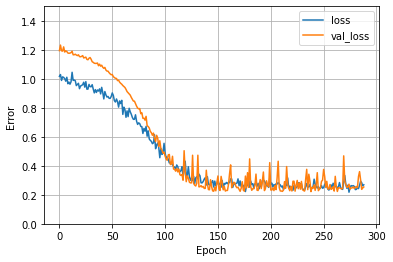

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Evaluate neural network

In [20]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.2540 - mse: 0.2540
loss test data:  0.25400885939598083
mse test data:  0.25400885939598083
7/7 [==============================] - 0s 2ms/step - loss: 0.2229 - mse: 0.2229
loss train data:  0.2228597104549408
mse train data:  0.2228597104549408


Plot results

<function matplotlib.pyplot.show>

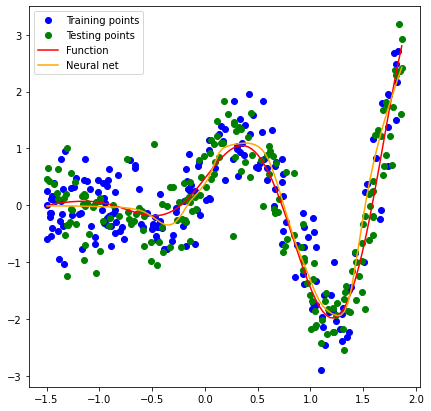

In [21]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show